In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline
import matplotlib.cm as cm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:

annual_features = pd.read_excel('/content/annual_features.xlsx')
annual_day_of_week_counts_pivot = pd.read_excel('/content/annual_day_of_week_counts_pivot.xlsx')
mth_rolling_features = pd.read_excel('/content/mth_rolling_features.xlsx')
mth_day_counts = pd.read_excel('/content/mth_day_counts.xlsx')
days_since_last_txn = pd.read_excel('/content/days_since_last_txn.xlsx')
retail_data_response = pd.read_csv('/content/Retail_Data_Response (1).csv')

# Annual features

In [3]:
print(annual_day_of_week_counts_pivot.shape)
print(annual_features.shape)
print(retail_data_response.shape)

(6889, 36)
(6889, 41)
(6884, 2)


In [4]:
# checking for missing rows
print('Missing rows: ',annual_features[~annual_features['customer_id'].isin(retail_data_response['customer_id'])].index)
print('Missing rows: ',annual_day_of_week_counts_pivot[~annual_day_of_week_counts_pivot['customer_id'].isin(retail_data_response['customer_id'])].index)
missing_rows_annual = annual_features[~annual_features['customer_id'].isin(retail_data_response['customer_id'])].index

Missing rows:  Int64Index([5185, 5301, 5526, 6264, 6641], dtype='int64')
Missing rows:  Int64Index([5185, 5301, 5526, 6264, 6641], dtype='int64')


In [5]:
# Drop missing rows
annual_features.drop(missing_rows_annual, inplace=True)
annual_day_of_week_counts_pivot.drop(missing_rows_annual, inplace=True)

In [6]:
# Reset index
annual_features.reset_index(drop=True,inplace= True)
annual_day_of_week_counts_pivot.reset_index(drop=True,inplace= True)

In [7]:
# merge the dataframes
annual_features_outputs = annual_features.merge(annual_day_of_week_counts_pivot, left_on='customer_id',right_on='customer_id')
annual_features_outputs = annual_features_outputs.merge(retail_data_response, left_on='customer_id',right_on='customer_id')

In [8]:
annual_features_outputs.shape


(6884, 77)

# Monthly features

In [9]:
mth_rolling_features.fillna(0,inplace=True)

In [10]:
mth_rolling_features.drop('Unnamed: 0',axis=1,inplace = True)

In [11]:
mth_day_counts.drop('Unnamed: 0',axis=1,inplace = True)

In [12]:
monthly_features_outputs = mth_rolling_features.merge(mth_day_counts,on = ['CLNT_NO',"ME_DT"])

In [13]:
days_since_last_txn.drop('Unnamed: 0',axis=1,inplace = True)

In [14]:
monthly_features_outputs = monthly_features_outputs.merge(days_since_last_txn,on = ['CLNT_NO',"ME_DT"])

In [15]:
monthly_features_outputs.rename({'CLNT_NO':'customer_id'},axis=1,inplace=True)

In [16]:
monthly_features_outputs=monthly_features_outputs.merge(retail_data_response,on='customer_id')

In [17]:
monthly_features_outputs.shape

(323548, 31)

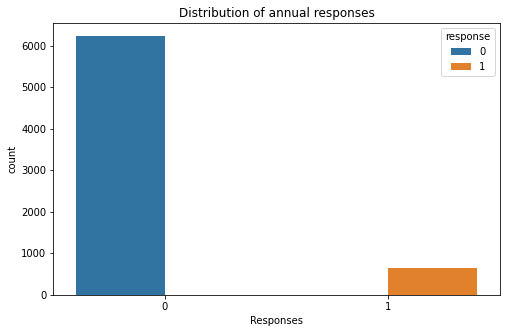

In [18]:
plt.figure(figsize = (8,5))
sns.countplot(annual_features_outputs['response'],hue = annual_features_outputs['response'] )
plt.title('Distribution of annual responses')
plt.xlabel('Responses')
plt.show()

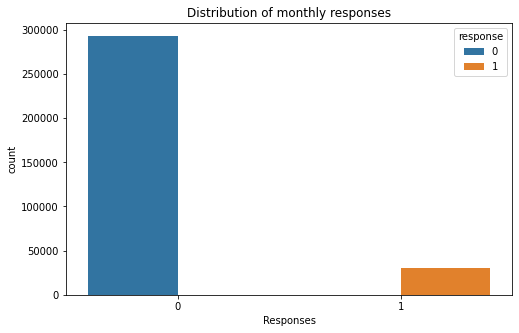

In [19]:
plt.figure(figsize = (8,5))
sns.countplot(monthly_features_outputs['response'],hue = monthly_features_outputs['response'] )
plt.title('Distribution of monthly responses')
plt.xlabel('Responses')
plt.show()

**The above plots for responses indicate the imbalanced nature of our dataset.**

# 1.2

In [20]:
X_annual = annual_features_outputs.iloc[:,1:-1]
Y_annual = annual_features_outputs.iloc[:,-1]
X_monthly = monthly_features_outputs.iloc[:,2:-1]
Y_monthly  = monthly_features_outputs.iloc[:,-1]

In [21]:
X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(X_annual, Y_annual, test_size=2/3, random_state=1147)
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, Y_monthly, test_size=2/3, random_state=1147)

In [22]:
scaler = StandardScaler()
X_train_annual_scaled = scaler.fit_transform(X_train_annual)
X_test_annual_scaled = scaler.transform(X_test_annual)

# Logistic Regression - Annual

In [23]:
c_range = [0.01,0.1,1,10,100]
estimator_c = []
accuracy_normalized = []
f1_train = []
f1_test = []

for i in range(5):
    # Define and fit
    estimator_c.append(LogisticRegression(penalty='l1', solver='liblinear', random_state=0, C = c_range[i]))
    estimator_c[i].fit(X_train_annual_scaled, y_train_annual)
    # Predict the class of train set
    y_train_predicted = estimator_c[i].predict(X_train_annual_scaled)
    # Predict the class of test set
    y_test_predicted = estimator_c[i].predict(X_test_annual_scaled)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_annual, y_test_predicted, normalize = True))
    # Calculate f1 score
    f1_train.append(f1_score(y_train_annual, y_train_predicted))
    f1_test.append(f1_score(y_test_annual, y_test_predicted))

performance_dictionary = {'Accuracy': accuracy_normalized,
                          'f1_TRAIN': f1_train,
                          'f1_TEST': f1_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['C'] = c_range
performance_df

,Accuracy,f1_TRAIN,f1_TEST,C
0,90.174292,0.000000,0.000000,0.01
1,89.934641,0.049261,0.017021,0.10
2,89.694989,0.136986,0.028747,1.00
3,89.629630,0.184211,0.048000,10.00
4,89.716776,0.184211,0.052209,100.00


In [24]:
model = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=0).fit(X_train_annual_scaled, y_train_annual)

# Plot for feature importance

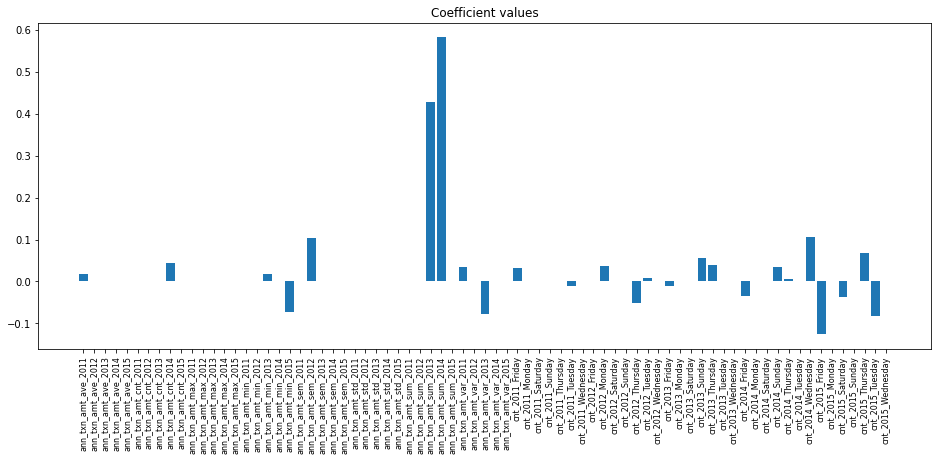

In [25]:
c = model.coef_
# Create plot
plt.figure(figsize=(16,6))
# Create plot title
plt.title("Coefficient values")
# Add bars
plt.bar(range(X_annual.shape[1]), c[0])
# Add feature names as x-axis labels
plt.xticks(range(X_annual.shape[1]), X_annual.columns, rotation=90,size=8)
# Show plot
plt.show()

# Plot for probability distribution for test set

Text(3.799999999999997, 0.5, 'Counts of clients')

<Figure size 864x720 with 0 Axes>

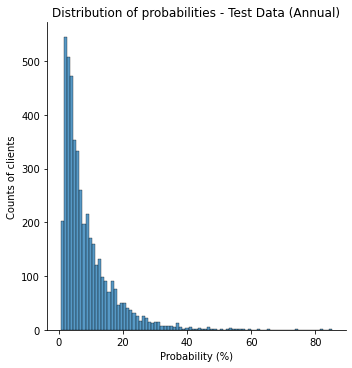

In [26]:
# 6. Plot probability distribution for test set

y_test_proba = pd.DataFrame(model.predict_proba(X_test_annual_scaled))
plt.figure(figsize=(12,10))
sns.displot(data = y_test_proba.iloc[:,1], x = 100 * y_test_proba.iloc[:,1])
plt.title('Distribution of probabilities - Test Data (Annual)')
plt.xlabel('Probability (%)')
plt.ylabel('Counts of clients')

# Confusion Matrix

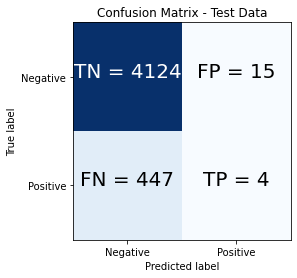

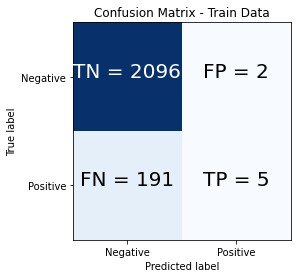

In [27]:
from sklearn.metrics import confusion_matrix

y_test_predicted = model.predict(X_test_annual_scaled)
y_train_predicted = model.predict(X_train_annual_scaled)

cm = confusion_matrix(y_test_annual, y_test_predicted)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()


cm = confusion_matrix(y_train_annual, y_train_predicted)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# Roc Curves

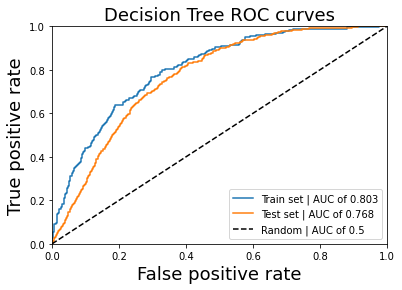

In [28]:
# ROC Calc Train set
from sklearn.metrics import roc_curve, auc
# Scores for train set
scores_train = model.predict_proba(X_train_annual_scaled)[:, 1]
# Scores for test set
scores_test = model.predict_proba(X_test_annual_scaled)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Decision Tree ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

# precision/recall

In [29]:
print(classification_report(y_test_annual, y_test_predicted, target_names = ['Negative(0)', 'Positive(1)']))

              precision    recall  f1-score   support

 Negative(0)       0.90      1.00      0.95      4139
 Positive(1)       0.21      0.01      0.02       451

    accuracy                           0.90      4590
   macro avg       0.56      0.50      0.48      4590
weighted avg       0.83      0.90      0.86      4590



# Decision Boundary

In [30]:
importances = model.coef_[0]
indices_log = np.argsort(importances)[::-1]
names_log = [X_train_annual.columns[i] for i in indices_log]

In [31]:
indices_log[:2]

array([33, 32])

In [32]:
print("Minimum Values:",(X_train_annual_scaled.min(axis=0)[32],X_train_annual_scaled.min(axis=0)[33]))
print("Maximum Values:",(X_train_annual_scaled.max(axis=0)[32],X_train_annual_scaled.max(axis=0)[33])) 

Minimum Values: (-1.6977424959358869, -1.755266718463368)
Maximum Values: (5.53912436943854, 3.824668181429266)


In [33]:
xx, yy = np.mgrid[-2.1:7, -2.2:7 ] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

(100, 2)


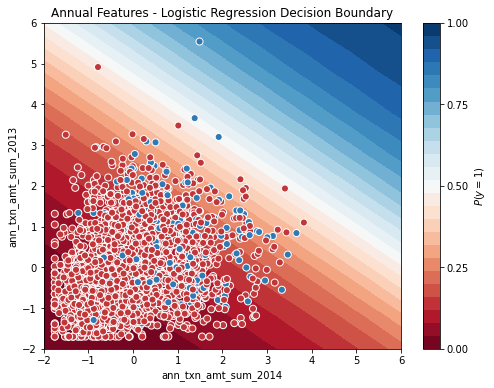

In [34]:
median_inputs = np.ones((grid.shape[0], X_train_annual_scaled.shape[1])) * np.median(X_train_annual_scaled, axis=0) 
# Replace the 14th and 15th column with the values of the grid
median_inputs[:,32] = grid[:,0]
median_inputs[:,33] = grid[:,1]

probs = model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_annual_scaled[50:,indices_log[:2][0]], X_train_annual_scaled[50:,indices_log[:2][1]], c=y_train_annual[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set_title('Annual Features - Logistic Regression Decision Boundary')
ax.set(aspect="auto",
       xlim=(-2, 6), ylim=(-2, 6),
       xlabel=names_log[:2][0], ylabel=names_log[:2][1])
plt.show()

# Decision Tree

In [35]:

# Initiate some parameters that I want to track in the iteration below
max_depth_range = range(1, 7)
estimator_max_depth = []
accuracy_normalized = []
f1_train           = []
f1_test            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(DecisionTreeClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_annual, y_train_annual)
    # Predict the class of train set
    y_train_predicted = estimator_max_depth[i-1].predict(X_train_annual)
    # Predict the class of test set
    y_test_predicted = estimator_max_depth[i-1].predict(X_test_annual)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_annual, y_test_predicted, normalize = True))
    # Calculate f1_score
    f1_train.append(f1_score(y_train_annual, y_train_predicted))
    f1_test.append(f1_score(y_test_annual, y_test_predicted))

In [36]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'f1_TRAIN': f1_train,
                          'f1_TEST': f1_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 1
performance_df

,ACCURACY,f1_TRAIN,f1_TEST,MAX_DEPTH
0,90.174292,0.000000,0.000000,1
1,90.174292,0.000000,0.000000,2
2,90.174292,0.010152,0.000000,3
3,89.455338,0.347490,0.126354,4
4,89.520697,0.423077,0.130199,5
5,89.259259,0.471483,0.111712,6


In [37]:
dt = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X_train_annual, y_train_annual)

# Plot for feature importance

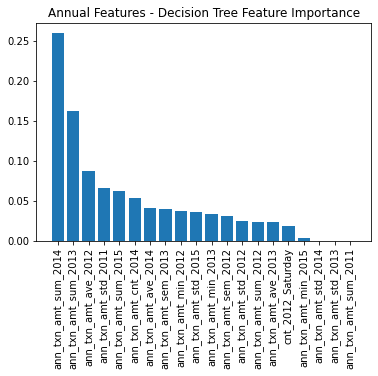

In [38]:
dt_feature_importances = dt.feature_importances_

indices_dt = np.argsort(dt_feature_importances)[::-1][:20]

# Rearrange feature names so they match the sorted feature importances
names_dt = [X_train_annual.columns[i] for i in indices_dt]

# Create plot
plt.figure()
# Create plot title
plt.title("Annual Features - Decision Tree Feature Importance")
# Add bars
plt.bar(range(20), dt_feature_importances[indices_dt])
# Add feature names as x-axis labels
plt.xticks(range(20), names_dt, rotation=90)
# Show plot
plt.show()

# Plot for probabilty distribution

<Figure size 432x288 with 0 Axes>

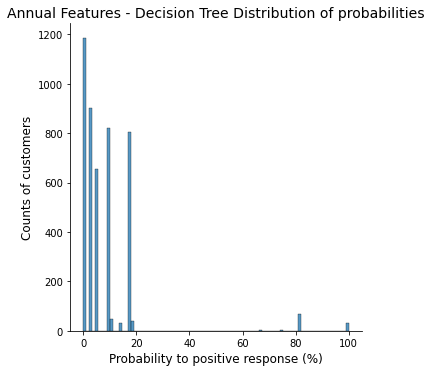

In [39]:
y_test_annual_proba_dt = pd.DataFrame(dt.predict_proba(X_test_annual))

plt.figure()
sns.displot(data = y_test_annual_proba_dt.iloc[:,1], x = 100*y_test_annual_proba_dt.iloc[:,1])
plt.title('Annual Features - Decision Tree Distribution of probabilities',fontsize=14)
plt.xlabel('Probability to positive response (%)',fontsize=12)
plt.ylabel('Counts of customers', fontsize=12)
plt.show()

# Confusion Matrix

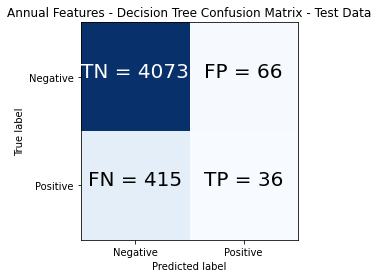

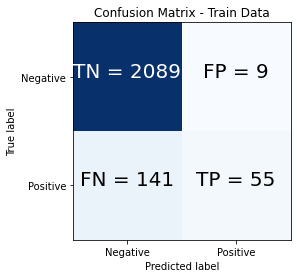

In [40]:
y_test_annual_predicted_dt = dt.predict(X_test_annual)
y_train_annual_predicted_dt = dt.predict(X_train_annual)
cm = confusion_matrix(y_test_annual, y_test_annual_predicted_dt)


plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Annual Features - Decision Tree Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

cm = confusion_matrix(y_train_annual, y_train_annual_predicted_dt)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# ROC curve

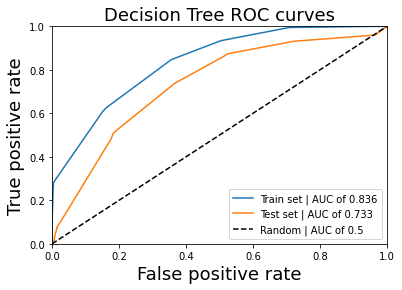

In [41]:
# Scores for train set
scores_train = dt.predict_proba(X_train_annual)[:, 1]
# Scores for test set
scores_test = dt.predict_proba(X_test_annual)[:, 1]

# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Decision Tree ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

# Precision and Recall

In [42]:
print(classification_report(y_test_annual, y_test_annual_predicted_dt, target_names = ['Negative(0)', 'Positive(1)']))

              precision    recall  f1-score   support

 Negative(0)       0.91      0.98      0.94      4139
 Positive(1)       0.35      0.08      0.13       451

    accuracy                           0.90      4590
   macro avg       0.63      0.53      0.54      4590
weighted avg       0.85      0.90      0.86      4590



# Decision Boundary

In [43]:
print("Minimum Values:",(X_train_annual.min(axis=0)[32],X_train_annual.min(axis=0)[33]))
print("Maximum Values:",(X_train_annual.max(axis=0)[32],X_train_annual.max(axis=0)[33])) 

Minimum Values: (0.0, 0.0)
Maximum Values: (1317.0, 974.0)


In [44]:
xx, yy = np.mgrid[-3:981:109, -3:1323:147 ] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

(100, 2)


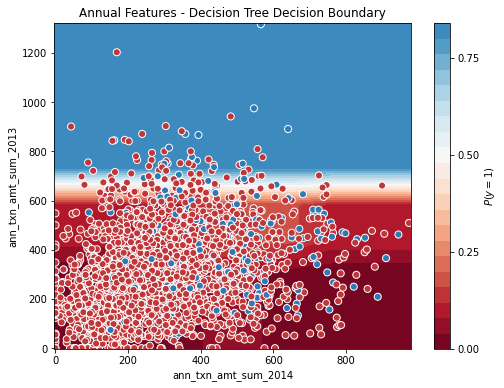

In [45]:
median_inputs = np.ones((grid.shape[0], X_train_annual.shape[1])) * np.median(X_train_annual, axis=0) 
# Replace the 14th and 15th column with the values of the grid
median_inputs[:,32] = grid[:,0]
median_inputs[:,33] = grid[:,1]

probs = dt.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_annual.iloc[50:,indices_dt[:2][0]], X_train_annual.iloc[50:,indices_dt[:2][1]], c=y_train_annual[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set_title('Annual Features - Decision Tree Decision Boundary')
ax.set(aspect="auto",
       xlim=(-3, 981), ylim=(-3, 1323),
       xlabel=names_dt[:2][0], ylabel=names_dt[:2][1])
plt.show()

# Random Forest

In [46]:

# Initiate some parameters that I want to track in the iteration below
max_depth_range = range(1,10)
estimator_max_depth = []
accuracy_normalized = []
f1_train           = []
f1_test            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(RandomForestClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_annual, y_train_annual)
    # Predict the class of train set
    y_train_predicted = estimator_max_depth[i-1].predict(X_train_annual)
    # Predict the class of test set
    y_test_predicted = estimator_max_depth[i-1].predict(X_test_annual)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_annual, y_test_predicted, normalize = True))
    # Calculate f1_score
    f1_train.append(f1_score(y_train_annual, y_train_predicted))
    f1_test.append(f1_score(y_test_annual, y_test_predicted))

In [47]:
performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'F1_TRAIN': f1_train,
                          'F1_TEST': f1_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 1
performance_df

,ACCURACY,F1_TRAIN,F1_TEST,MAX_DEPTH
0,90.174292,0.000000,0.0,1
1,90.174292,0.000000,0.0,2
2,90.174292,0.000000,0.0,3
3,90.174292,0.000000,0.0,4
4,90.174292,0.000000,0.0,5
5,90.174292,0.010152,0.0,6
6,90.174292,0.159624,0.0,7
7,90.152505,0.257778,0.0,8
8,90.174292,0.456693,0.0,9


In [48]:
rf = RandomForestClassifier(max_depth=6, random_state=0).fit(X_train_annual, y_train_annual)

# Plot for feature importance

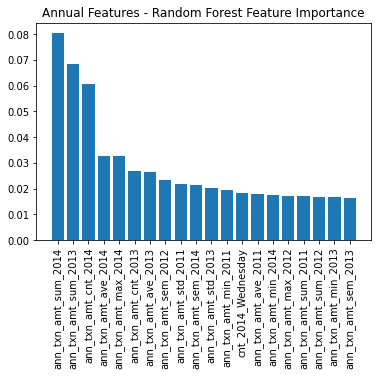

In [50]:

rf_feature_importances = rf.feature_importances_
indices_rf = np.argsort(rf_feature_importances)[::-1][:20]
# Rearrange feature names so they match the sorted feature importances
names_rf = [X_train_annual.columns[i] for i in indices_rf]

# Create plot
plt.figure()
# Create plot title

plt.title("Annual Features - Random Forest Feature Importance")
# Add bars
plt.bar(range(20), rf_feature_importances[indices_rf])
# Add feature names as x-axis labels
plt.xticks(range(20), names_rf, rotation=90)
# Show plot
plt.show()

# Plot for probability distribution

<Figure size 432x288 with 0 Axes>

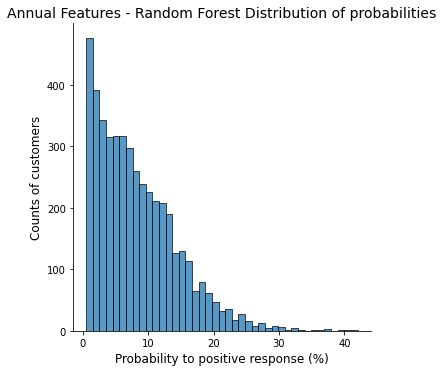

In [51]:
y_test_annual_proba = pd.DataFrame(rf.predict_proba(X_test_annual))
plt.figure()
sns.displot(data = y_test_annual_proba.iloc[:,1], x = 100*y_test_annual_proba.iloc[:,1])
plt.title('Annual Features - Random Forest Distribution of probabilities',fontsize=14)
plt.xlabel('Probability to positive response (%)',fontsize=12)
plt.ylabel('Counts of customers', fontsize=12)
plt.show()

# Confusion Matrix

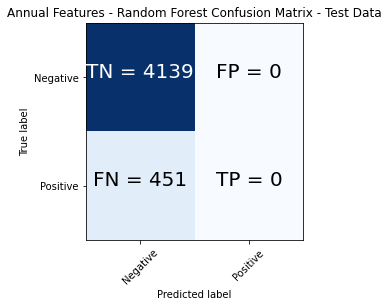

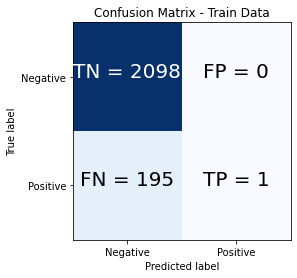

In [52]:
y_test_annual_predicted_rf = rf.predict(X_test_annual)
cm = confusion_matrix(y_test_annual, y_test_annual_predicted_rf)


plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Annual Features - Random Forest Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

y_train_annual_predicted_rf = rf.predict(X_train_annual)
cm = confusion_matrix(y_train_annual, y_train_annual_predicted_rf)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# Roc Curve

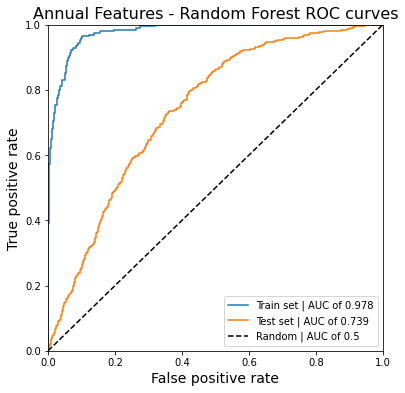

In [53]:
# Scores for train set
scores_train = rf.predict_proba(X_train_annual)[:, 1]
# Scores for test set
scores_test = rf.predict_proba(X_test_annual)[:, 1]

# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

# Plotting
fig = plt.figure(figsize=(6,6))
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Annual Features - Random Forest ROC curves', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 14)
plt.xlabel('False positive rate', fontsize = 14)
plt.legend(loc='lower right')
plt.show()

# Precision and Recall

In [54]:
print(classification_report(y_test_annual, y_test_annual_predicted_rf, target_names = ['Negative(0)', 'Positive(1)']))

              precision    recall  f1-score   support

 Negative(0)       0.90      1.00      0.95      4139
 Positive(1)       0.00      0.00      0.00       451

    accuracy                           0.90      4590
   macro avg       0.45      0.50      0.47      4590
weighted avg       0.81      0.90      0.86      4590



In [55]:
print("Minimum Values:",(X_train_annual.min(axis=0)[indices_rf[:2][0]],X_train_annual.min(axis=0)[indices_rf[:2][1]]))
print("Maximum Values:",(X_train_annual.max(axis=0)[indices_rf[:2][0]],X_train_annual.max(axis=0)[indices_rf[:2][1]])) 

Minimum Values: (0.0, 0.0)
Maximum Values: (974.0, 1317.0)


In [56]:
xx, yy = np.mgrid[-5:981:109, -5:1323:147] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

median_inputs = np.ones((100, 75)) * np.median(X_train_annual, axis=0) 

# Replace the 5th and 4th column with the values of the grid
median_inputs[:,33] = grid[:,0]
median_inputs[:,32] = grid[:,1]

(100, 2)


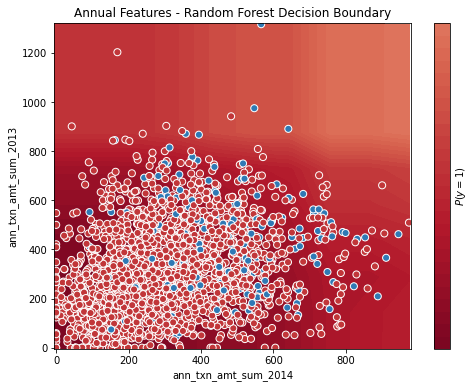

In [57]:
probs = rf.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_annual.iloc[50:,indices_rf[0]], X_train_annual.iloc[50:,indices_rf[1]], c=y_train_annual[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set_title('Annual Features - Random Forest Decision Boundary')
ax.set(aspect="auto",
       xlim=(-5, 981), ylim=(-5, 1323),
       xlabel=names_rf[0], ylabel=names_rf[1])

plt.show()

# Monthly Features

# Logistic regeression

In [58]:
X_train_monthly_scaled = scaler.fit_transform(X_train_monthly)
X_test_monthly_scaled = scaler.transform(X_test_monthly)

In [59]:
c_range = [0.01,0.1,1,10,100]
estimator_c = []
accuracy_normalized = []
f1_train = []
f1_test = []
Recall_test = []

for i in range(5):
    # Define and fit
    estimator_c.append(LogisticRegression(penalty='l1', solver='liblinear', random_state=0, C = c_range[i]))
    estimator_c[i].fit(X_train_monthly_scaled, y_train_monthly)
    # Predict the class of train set
    y_train_predicted = estimator_c[i].predict(X_train_monthly_scaled)
    # Predict the class of test set
    y_test_predicted = estimator_c[i].predict(X_test_monthly_scaled)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True))
   
    f1_train.append(f1_score(y_train_monthly, y_train_predicted))
    f1_test.append(f1_score(y_test_monthly, y_test_predicted))
    Recall_test.append(recall_score(y_test_monthly, y_test_predicted))

performance_dictionary = {'Accuracy': accuracy_normalized,
                          'f1_TRAIN': f1_train,
                          'f1_TEST': f1_test,
                          'Recall':Recall_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['C'] = c_range
performance_df

,Accuracy,f1_TRAIN,f1_TEST,Recall,C
0,90.58781,0.0,0.0,0.0,0.01
1,90.58781,0.0,0.0,0.0,0.10
2,90.58781,0.0,0.0,0.0,1.00
3,90.58781,0.0,0.0,0.0,10.00
4,90.58781,0.0,0.0,0.0,100.00


In [60]:
model_mon = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=0).fit(X_train_monthly_scaled, y_train_monthly)

In [61]:
m = model_mon.coef_
b = model_mon.intercept_
b

array([-2.33782118])

In [62]:
importances = model_mon.coef_[0]
indices_log_mon = np.argsort(importances)[::-1]

# Plot for feature importance

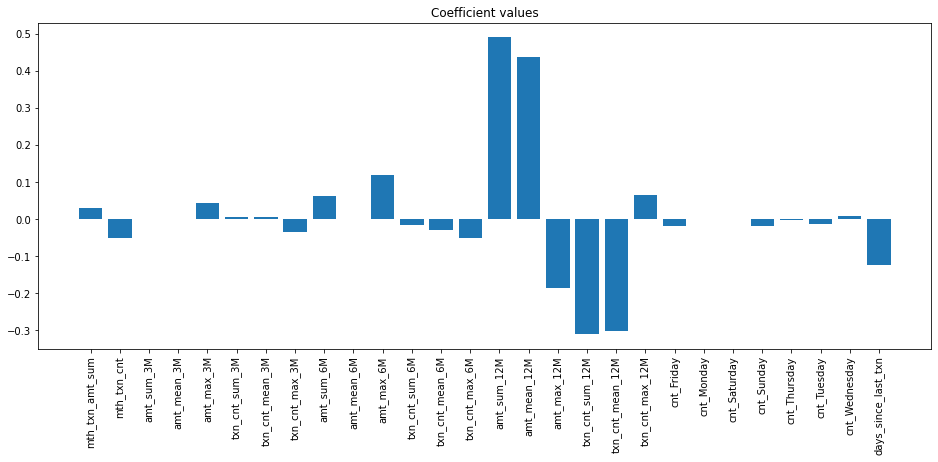

In [63]:
# Create plot
plt.figure(figsize=(16,6))
# Create plot title
plt.title("Coefficient values")
# Add bars
plt.bar(range(X_monthly.shape[1]), m[0])
# Add feature names as x-axis labels
plt.xticks(range(X_monthly.shape[1]), X_monthly.columns, rotation=90)
# Show plot
plt.show()

# Confusion Matrix

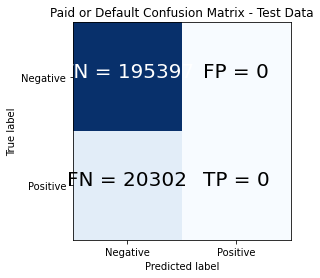

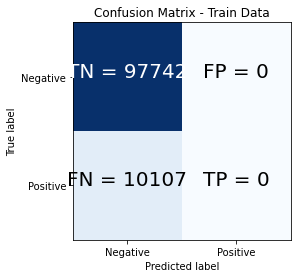

In [64]:
from sklearn.metrics import confusion_matrix

y_test_predicted_mon = model_mon.predict(X_test_monthly_scaled)
y_train_predicted_mon = model_mon.predict(X_train_monthly_scaled)
cm = confusion_matrix(y_test_monthly, y_test_predicted_mon)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Paid or Default Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

cm = confusion_matrix(y_train_monthly, y_train_predicted_mon)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# Probabilty distribution

Text(-8.825000000000003, 0.5, 'Counts of clients')

<Figure size 360x360 with 0 Axes>

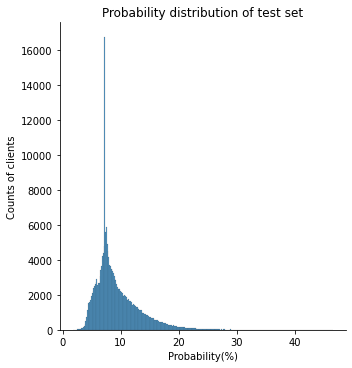

In [65]:
y_test_proba_m = pd.DataFrame(model_mon.predict_proba(X_test_monthly_scaled))
plt.figure(figsize=(5,5))
sns.displot(data = y_test_proba_m.iloc[:,1], x = 100*y_test_proba_m.iloc[:,1])
plt.title('Probability distribution of test set')
plt.xlabel('Probability(%)')
plt.ylabel('Counts of clients')

# Roc curve

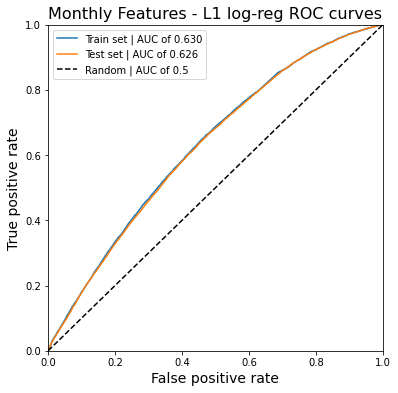

In [66]:
scores_train = model_mon.predict_proba(X_train_monthly_scaled)[:, 1]

scores_test = model_mon.predict_proba(X_test_monthly_scaled)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

# Plotting
fig = plt.figure(figsize=(6,6))
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Monthly Features - L1 log-reg ROC curves', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 14)
plt.xlabel('False positive rate', fontsize = 14)
plt.legend()
plt.show()

# Precision and Recall

In [67]:
print(classification_report(y_test_monthly,y_test_predicted_mon))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    195397
           1       0.00      0.00      0.00     20302

    accuracy                           0.91    215699
   macro avg       0.45      0.50      0.48    215699
weighted avg       0.82      0.91      0.86    215699



# Decision Boundary

In [68]:
X_train_monthly_scaled = pd.DataFrame(X_train_monthly_scaled)
importances_mon = model_mon.coef_[0]
indices_log_mon = np.argsort(importances_mon)[::-1]
names_log_mon = [X_train_monthly_scaled.columns[i] for i in indices_log_mon]

In [69]:
indices_log_mon[:2]

array([14, 15])

In [70]:
print("Minimum Values:",(X_train_monthly_scaled.min(axis=0)[14],X_train_monthly_scaled.min(axis=0)[15]))
print("Maximum Values:",(X_train_monthly_scaled.max(axis=0)[14],X_train_monthly_scaled.max(axis=0)[15])) 

Minimum Values: (-1.1658179438201837, -1.1658179438201839)
Maximum Values: (4.862714417611841, 4.862714417611843)


In [71]:
xx, yy = np.mgrid[-2:6:0.888, -2:6:0.888] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

(100, 2)


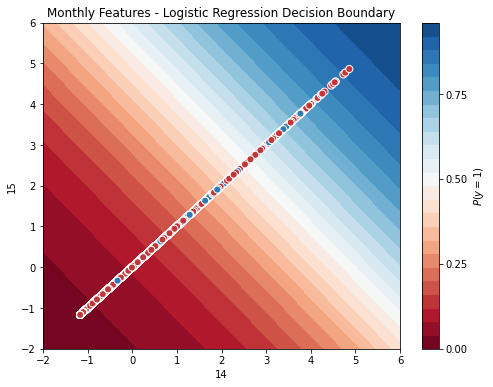

In [72]:
median_inputs = np.ones((100, 28)) * np.median(X_train_monthly_scaled, axis=0) 

# Replace the 14th and 15th column with the values of the grid
median_inputs[:,14] = grid[:,0]
median_inputs[:,15] = grid[:,1]

probs = model_mon.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_monthly_scaled.iloc[50:,indices_log_mon[:2][0]], X_train_monthly_scaled.iloc[50:,indices_log_mon[:2][1]], c=y_train_monthly.iloc[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set_title('Monthly Features - Logistic Regression Decision Boundary')
ax.set(aspect="auto",
       xlim=(-2, 6), ylim=(-2, 6),
       xlabel=names_log_mon[:2][0], ylabel=names_log_mon[:2][1])
plt.show()

# Decision Trees

In [73]:
# Initiate some parameters that I want to track in the iteration below
max_depth_range = range(1, 7)
estimator_max_depth = []
accuracy_normalized = []
f1_train           = []
f1_test            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(DecisionTreeClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_monthly, y_train_monthly)
    # Predict the class of train set
    y_train_predicted = estimator_max_depth[i-1].predict(X_train_monthly)
    # Predict the class of test set
    y_test_predicted = estimator_max_depth[i-1].predict(X_test_monthly)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True))
    # Calculate f1
    f1_train.append(f1_score(y_train_monthly, y_train_predicted))
    f1_test.append(f1_score(y_test_monthly, y_test_predicted))

performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'f1': f1_train,
                          'f1': f1_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 1
performance_df

,ACCURACY,f1,MAX_DEPTH
0,90.587810,0.000000,1
1,90.587810,0.000000,2
2,90.587810,0.000000,3
3,90.586419,0.000098,4
4,90.573438,0.002747,5
5,90.571584,0.003235,6


In [74]:
dt_mon = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X_train_monthly, y_train_monthly)

# Plot for feature importance

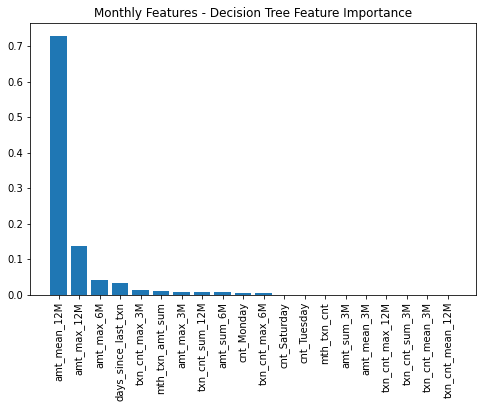

In [75]:
dt_feature_importances_mon = dt_mon.feature_importances_
indices_dt_mon = np.argsort(dt_feature_importances_mon)[::-1][:20]

# Rearrange feature names so they match the sorted feature importances
names_dt_mon  = [X_train_monthly.columns[i] for i in indices_dt_mon]

# Create plot
plt.figure(figsize=(8,5))
# Create plot title
plt.title("Monthly Features - Decision Tree Feature Importance")
# Add bars
plt.bar(range(20), dt_feature_importances_mon[indices_dt_mon])
# Add feature names as x-axis labels
plt.xticks(range(20), names_dt_mon, rotation=90)
# Show plot
plt.show()

# Plot for probability distribution

<Figure size 576x360 with 0 Axes>

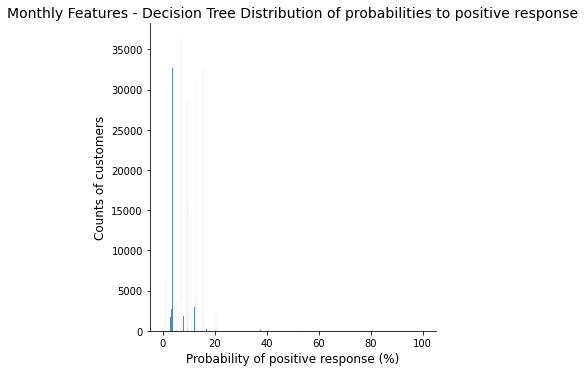

In [76]:
y_test_monthly_proba = pd.DataFrame(dt_mon.predict_proba(X_test_monthly))

plt.figure(figsize=(8,5))
sns.displot(data = y_test_monthly_proba.iloc[:,1], x = 100*y_test_monthly_proba.iloc[:,1])
plt.title('Monthly Features - Decision Tree Distribution of probabilities to positive response',fontsize=14)
plt.xlabel('Probability of positive response (%)',fontsize=12)
plt.ylabel('Counts of customers', fontsize=12)
plt.show()

# Confusion matrix

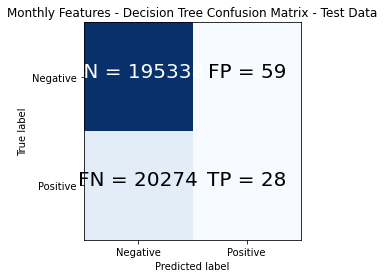

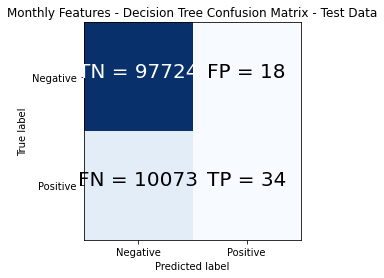

In [77]:
y_test_monthly_predicted_dt = dt_mon.predict(X_test_monthly)
cm = confusion_matrix(y_test_monthly, y_test_monthly_predicted_dt)


plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Monthly Features - Decision Tree Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

y_train_monthly_predicted = dt_mon.predict(X_train_monthly)
cm = confusion_matrix(y_train_monthly, y_train_monthly_predicted)


plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Monthly Features - Decision Tree Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()




# Roc curve

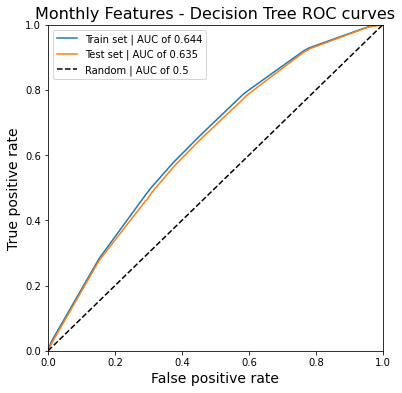

In [78]:
# Scores for train set
scores_train = dt_mon.predict_proba(X_train_monthly)[:, 1]
# Scores for test set
scores_test = dt_mon.predict_proba(X_test_monthly)[:, 1]

# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

# Plotting
fig = plt.figure(figsize=(6,6))
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Monthly Features - Decision Tree ROC curves', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 14)
plt.xlabel('False positive rate', fontsize = 14)
plt.legend()
plt.show()

# Precision and Recall

In [79]:
print(classification_report(y_test_monthly,y_test_monthly_predicted_dt))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    195397
           1       0.32      0.00      0.00     20302

    accuracy                           0.91    215699
   macro avg       0.61      0.50      0.48    215699
weighted avg       0.85      0.91      0.86    215699



# Decision Boundary

In [80]:
indices_dt_mon[:2]

array([15, 16])

In [81]:
print("Minimum Values:",(X_train_monthly.min(axis=0)[15],X_train_monthly.min(axis=0)[16]))
print("Maximum Values:",(X_train_monthly.max(axis=0)[15],X_train_monthly.max(axis=0)[16])) 

Minimum Values: (0.0, 0.0)
Maximum Values: (101.4166666666667, 460.0)


In [82]:
xx, yy = np.mgrid[-5:115:13, -5:460:51] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

(100, 2)


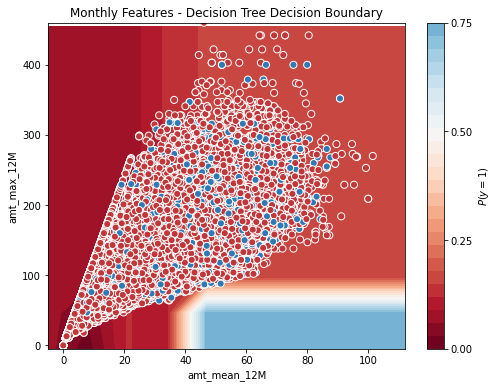

In [83]:
median_inputs = np.ones((100, 28)) * np.median(X_train_monthly, axis=0) 

# Replace the 5th and 4th column with the values of the grid
median_inputs[:,15] = grid[:,0]
median_inputs[:,16] = grid[:,1]

probs = dt_mon.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_monthly.iloc[50:,15], X_train_monthly.iloc[50:,16], c=y_train_monthly[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set_title('Monthly Features - Decision Tree Decision Boundary')
ax.set(aspect="auto",
       xlim=(-5, 112), ylim=(-5, 460),
       xlabel=names_dt_mon[0], ylabel=names_dt_mon[1])

plt.show()

# Random Forest

In [84]:
# Initiate some parameters that I want to track in the iteration below
max_depth_range = range(1, 7)
estimator_max_depth = []
accuracy_normalized = []
f1_train           = []
f1_test            = []

for i in max_depth_range:
    # Define and fit
    estimator_max_depth.append(RandomForestClassifier(random_state=0, max_depth = i))
    estimator_max_depth[i-1].fit(X_train_monthly, y_train_monthly)
    # Predict the class of train set
    y_train_predicted = estimator_max_depth[i-1].predict(X_train_monthly)
    # Predict the class of test set
    y_test_predicted = estimator_max_depth[i-1].predict(X_test_monthly)
    # Calculate accuracy at every iteration and append
    accuracy_normalized.append(100*accuracy_score(y_test_monthly, y_test_predicted, normalize = True))
    # Calculate f1
    f1_train.append(f1_score(y_train_monthly, y_train_predicted))
    f1_test.append(f1_score(y_test_monthly, y_test_predicted))

performance_dictionary = {'ACCURACY': accuracy_normalized, 
                          'f1_TRAIN': f1_train,
                          'f1_TEST': f1_test}
performance_df = pd.DataFrame(performance_dictionary)
performance_df['MAX_DEPTH'] = performance_df.index + 1
performance_df    

,ACCURACY,f1_TRAIN,f1_TEST,MAX_DEPTH
0,90.58781,0.000000,0.0,1
1,90.58781,0.000000,0.0,2
2,90.58781,0.000000,0.0,3
3,90.58781,0.000000,0.0,4
4,90.58781,0.000000,0.0,5
5,90.58781,0.000198,0.0,6


In [85]:
rf_mon = RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_monthly, y_train_monthly)

In [86]:
rf_feature_importances_mon = rf_mon.feature_importances_
# Sort feature importances in descending order
indices_rf_mon = np.argsort(rf_feature_importances_mon)[::-1][:20]
names_rf_mon = [X_train_monthly.columns[i] for i in indices_rf_mon]

# Plot for feature importance

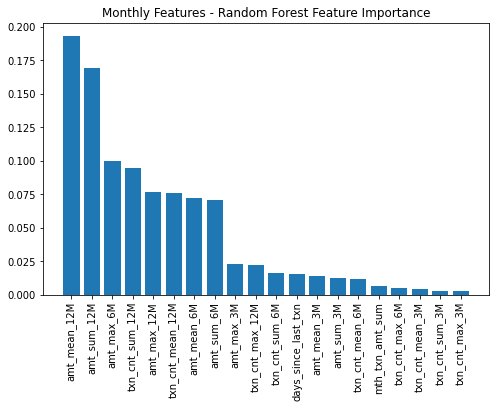

In [87]:
# Create plot
plt.figure(figsize=(8,5))
# Create plot title
plt.title("Monthly Features - Random Forest Feature Importance")
# Add bars
plt.bar(range(20), rf_feature_importances_mon[indices_rf_mon])
# Add feature names as x-axis labels
plt.xticks(range(20), names_rf_mon, rotation=90)
# Show plot
plt.show()

# Plot for probabilty distribution

<Figure size 432x288 with 0 Axes>

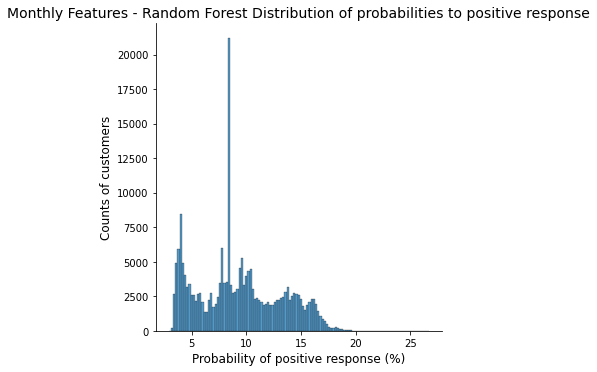

In [88]:
y_test_monthly_proba = pd.DataFrame(rf_mon.predict_proba(X_test_monthly))
plt.figure()
sns.displot(data = y_test_monthly_proba.iloc[:,1], x = 100*y_test_monthly_proba.iloc[:,1])
plt.title('Monthly Features - Random Forest Distribution of probabilities to positive response',fontsize=14)
plt.xlabel('Probability of positive response (%)',fontsize=12)
plt.ylabel('Counts of customers', fontsize=12)
plt.show()

# Confusion Matrix

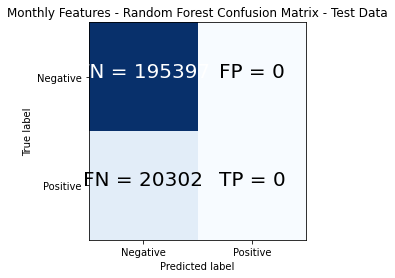

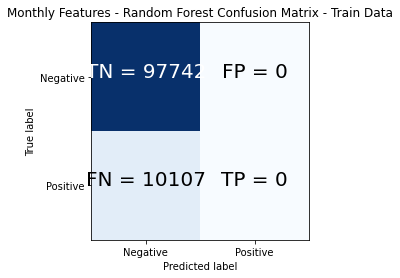

In [89]:
y_test_monthly_predicted_rf = rf_mon.predict(X_test_monthly)
cm = confusion_matrix(y_test_monthly, y_test_monthly_predicted_rf)


plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Monthly Features - Random Forest Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

y_train_monthly_predicted_rf = rf_mon.predict(X_train_monthly)
cm = confusion_matrix(y_train_monthly, y_train_monthly_predicted_rf)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Monthly Features - Random Forest Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# Roc Curve

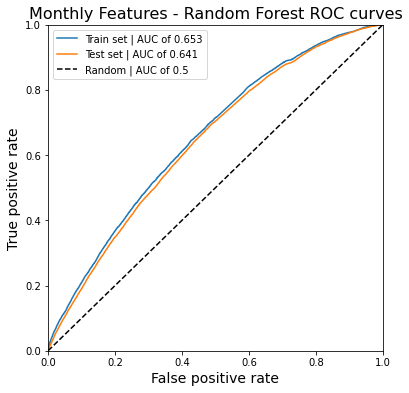

In [90]:
# Scores for train set
scores_train = rf_mon.predict_proba(X_train_monthly)[:, 1]
# Scores for test set
scores_test = rf_mon.predict_proba(X_test_monthly)[:, 1]

# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

# Plotting
fig = plt.figure(figsize=(6,6))
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Monthly Features - Random Forest ROC curves', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 14)
plt.xlabel('False positive rate', fontsize = 14)
plt.legend()
plt.show()

# Precision and Recall

In [91]:
print(classification_report(y_test_monthly,y_test_monthly_predicted_rf))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    195397
           1       0.00      0.00      0.00     20302

    accuracy                           0.91    215699
   macro avg       0.45      0.50      0.48    215699
weighted avg       0.82      0.91      0.86    215699



# Decision Boundary

In [92]:
print(indices_rf_mon[:2])


[15 14]


In [93]:
print("Minimum Values:",(X_train_monthly.min(axis=0)[14],X_train_monthly.min(axis=0)[15]))
print("Maximum Values:",(X_train_monthly.max(axis=0)[14],X_train_monthly.max(axis=0)[15])) 

Minimum Values: (0.0, 0.0)
Maximum Values: (1217.0, 101.4166666666667)


In [94]:
xx, yy = np.mgrid[-5:112:12.9999, -5:1323:147] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

(100, 2)


In [95]:
median_inputs = np.ones((100, 28)) * np.median(X_train_monthly, axis=0) 

# Replace the 5th and 4th column with the values of the grid
median_inputs[:,15] = grid[:,0]
median_inputs[:,14] = grid[:,1]

probs = rf_mon.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

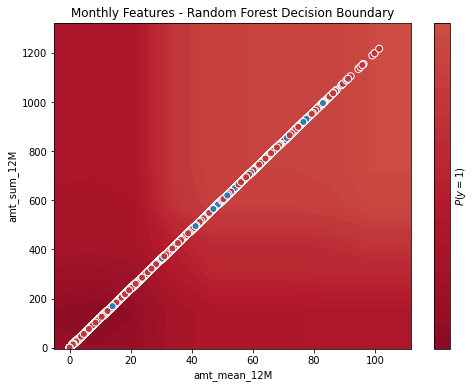

In [96]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_monthly.iloc[50:,15], X_train_monthly.iloc[50:,14], c=y_train_monthly[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.set_title('Monthly Features - Random Forest Decision Boundary')
ax.set(aspect="auto",
       xlim=(-5,112), ylim=(-5, 1323),
       xlabel=names_rf_mon[0], ylabel=names_rf_mon[1])

plt.show()

# Discussion

|Feature type  | Model  | coefficient values | Probability distribution |  AUC score - Train |AUC score - Test| Precision| Recall| Confusion Matrix (FN) | Test Accuracy |
| ------------- | ------------- | ------------- | --- |  --- |----|--|---|---| ---|
| Annual | L1 logistic regression|High positive coefficient values for two features | about 15%  probabilty of More than 500 clients to give a positive response |0.803|0.763 |0.56|0.50 | 447 |  90%|
|        | Decision Tree|Number of features with high importance | 5% - 20% probablity of a positve response | 0.86| 0.73| 0.63|0.53|441|90%|
|        | Random Forest|Number of features with high importance| 5% - 45% probabiltiy of a positive response| 0.978|0.739 |0.45|0.50| 451| 90%
| Monthly| L1 logistic regression|High positive coefficient values for two features   |Low probability for positive response |0.629|0.626 | 0.45|0.5 | 20302 | 91%|
|        | Decision Tree| amt_mean_12M has high coefficient value | low probability of a positive response | 0.64| 0.63| 0.61 |0.65|20274 | 91%
|        | Random Forest| more number of features with high coefficient value |  low probability of a positive response| 0.653|0.641| 0.45 |0.5|20302 | 91%

The decision boundary plot for both monthly and annual features when using the Random Forest algorithm were unable to classify the two classes appropriately. However the decision boundaries for logistic regression and decision trees were valid but failed to convey any important information. The reason could be the imbalanced nature of our dataset which makes it difficult for the model to generalize the difference between the positive and negative labels.

After comparing the performance of all models, I would select the model that implements decision tree algorithm with monthly features. 
The model has highest precision,recall and accuracy scores as compared to all other models. Annual features do not seem to have a lot of data when compared to monthly features